In [ ]:
import pandas as pd
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)
from time import sleep
import time
import pickle
import sklearn
%matplotlib inline
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, f1_score

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
from multiprocessing import Pool
import scipy.stats as stats

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 1.x
except Exception:
  pass

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
import os
import pickle
from keras.models import load_model
from tensorflow.keras.optimizers.schedules import PolynomialDecay,ExponentialDecay

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  import sys


TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
#pip install torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(tf.__version__)

1.15.2


In [ ]:
#pip install patool pyunpack 

In [ ]:
#pip install py7zr 

In [ ]:
#was unzipping the compressed folder

#import pyunpack
#pyunpack.Archive('/content/drive/MyDrive/MSS_raw_data.rar').extractall('/content/drive/MyDrive/data/')

In [ ]:

## Reading all the files in the data directory

# from os import listdir
# path = '/content/drive/MyDrive/data/MSS_raw_data/'
# files = [f for f in listdir(path=path)]

# ## Creating columns

# temp = pd.read_csv(f'{path}/{files[0]}',header=None,skiprows= [0])
# size = temp.shape[0]
# cols = [f'vr{c}' for c in range(1,size+1)]
# cols.insert(0,'Rdist')

# # cols used for creating an empty data frame below for appending all generated signals
# data = pd.DataFrame(data=None,columns=cols)


# ## Merging all the generated files
# ## Each row consists of the independent vairable Rdist (first column) 
# ## and the dependent vairiable, the recieved voltage signal (the remaining columns)


# count = 0 
# for f in files:
#   df = pd.read_csv(f'{path}/{f}',header=None,skiprows= [0])
#   rdist = df.iloc[0,0]   #taking the first element from the csv file
#   temp = df.iloc[:,1].values.tolist()  
#   temp.insert(0,rdist)
#   data.loc[count]=temp
#   count+=1
  #print(count)
  


In [ ]:
# HDF5 format are good for verly large datasets and they have great speed
#data.to_hdf('/content/drive/MyDrive/data/store_data.h5',key='table',mode='w')

In [ ]:
data = pd.read_hdf('/content/drive/MyDrive/data/store_data.h5',key='table',mode='r')
# df= data.iloc[300,1:].rolling(512).mean()
data.sort_values(by='Rdist',axis=0,inplace=True)
# data = data[:500]
# data = data.sample(frac=1)

In [ ]:
data[data.iloc[:,1:]<0]=0
data = data.sample(frac=1)

In [ ]:
for i in range(data.shape[0]):

  data.iloc[i,1:] = data.iloc[i,1:].rolling(512).mean()

In [ ]:
data.fillna(0,inplace=True)

In [ ]:
print(data.shape)
data.head()

(500, 262145)


,Rdist,vr1,vr2,vr3,vr4,vr5,vr6,vr7,vr8,vr9,vr10,vr11,vr12,vr13,vr14,vr15,vr16,vr17,vr18,vr19,vr20,vr21,vr22,vr23,vr24,vr25,vr26,vr27,vr28,vr29,vr30,vr31,vr32,vr33,vr34,vr35,vr36,vr37,vr38,vr39,...,vr262105,vr262106,vr262107,vr262108,vr262109,vr262110,vr262111,vr262112,vr262113,vr262114,vr262115,vr262116,vr262117,vr262118,vr262119,vr262120,vr262121,vr262122,vr262123,vr262124,vr262125,vr262126,vr262127,vr262128,vr262129,vr262130,vr262131,vr262132,vr262133,vr262134,vr262135,vr262136,vr262137,vr262138,vr262139,vr262140,vr262141,vr262142,vr262143,vr262144
188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.798854e-14
202,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.054615e-06,1.053636e-06,1.053636e-06,1.060975e-06,1.075230e-06,1.088459e-06,1.090033e-06,1.086432e-06,1.083905e-06,1.083905e-06,1.083905e-06,1.095354e-06,1.114671e-06,1.129353e-06,1.127656e-06,1.124592e-06,1.122552e-06,1.122552e-06,1.124574e-06,1.139800e-06,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,1.241628e-06
211,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.354349e-06,1.350968e-06,1.350968e-06,1.359198e-06,1.377093e-06,1.394445e-06,1.399790e-06,1.395790e-06,1.391143e-06,1.388722e-06,1.388722e-06,1.400990e-06,1.423710e-06,1.442666e-06,1.444206e-06,1.440198e-06,1.436038e-06,1.434190e-06,1.434190e-06,1.450714e-06,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,1.577378e-06
222,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.136860e-06,1.133823e-06,1.133040e-06,1.138296e-06,1.154546e-06,1.172549e-06,1.181173e-06,1.179152e-06,1.175903e-06,1.173382e-06,1.173064e-06,1.182810e-06,1.204295e-06,1.223998e-06,1.229278e-06,1.227157e-06,1.223883e-06,1.221403e-06,1.221251e-06,1.235085e-06,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,1.377608e-06
233,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.864926e-07,8.846481e-07,8.846481e-07,8.892377e-07,9.035568e-07,9.196093e-07,9.271048e-07,9.251954e-07,9.230308e-07,9.219266e-07,9.219266e-07,9.306450e-07,9.503033e-07,9.684926e-07,9.729743e-07,9.713661e-07,9.695073e-07,9.684334e-07,9.684334e-07,9.813639e-07,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,1.116665e-06


In [ ]:
# fftpoints = 262144
# sample_freq = 1e6/4
# total_time = fftpoints/sample_freq
# t = total_time*np.linspace(0,1,num=fftpoints)

plt.plot(data.iloc[:,1:].values[:10])

In [ ]:
# temp = data.drop('Rdist',axis=1)
# ts = []
# for i in range (0,data.shape[0]):
#   ts.append([t,list(temp.loc[i].values)])
#   i+=1

In [ ]:
ts = np.array(ts)

In [ ]:
# # normalizing the data

# for i in range (0,ts.shape[0]):
#   x = ts[i][1]
#   new = ((x-np.min(x))/(np.max(x)-np.min(x)))
#   ts[i][1] = new

###Each signal has 262144 data points represented by all vr... columns

In [ ]:
dt = data.drop('Rdist',axis=1).values
Train_Test = np.array(dt[0:800] )                             # training data
Val = np.array(dt[800:])                                      # validation data
# dt2 = data.drop('Rdist',axis=1).values
color = data['Rdist'].iloc[0:800]


In [ ]:
# Scaling the data to minimise reconstruction error
Train_Test = np.array([((x-np.min(x))/(np.max(x)-np.min(x))) for x in Train_Test])
Val = np.array([((x-np.min(x))/(np.max(x)-np.min(x))) for x in Val])
# dt = np.array(dt)
# dt2 = np.array(dt2)

In [ ]:
X = Train_Test
# X_train, X_test = train_test_split(X,test_size=0.75,shuffle=False);          #splitting the data
# plot_index = np.random.randint(0,100)                                       #reconstruction index
X_train, X_test = Train_Test, Val
test_color = data['Rdist'].iloc[800:]                                                      # Distance for test data shape = 225
X_val = Val                                                                   #Validation data

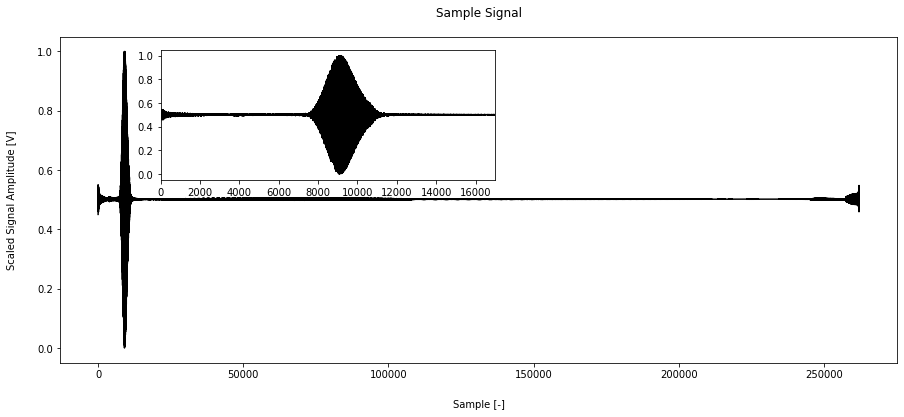

In [ ]:
fig,ax1 =plt.subplots(figsize=(15,6))
ax1.plot(dt[899],color='black')

ax2 = plt.axes([15250,0.4,3000,0.5])

ip = InsetPosition(ax1, [0.12,0.56,0.4,0.4])
ax2.set_axes_locator(ip)

ax2.plot(dt[899],color='black')
ax2.set_xlim(0,17000)

ax1.set_xlabel('Sample [-]',labelpad=20)
ax1.set_ylabel('Scaled Signal Amplitude [V]',labelpad=20)
ax1.set_title('Sample Signal',pad=20)
plt.savefig('/content/drive/MyDrive/data/sample_signal.png')


####Init PCA Model

In [ ]:
# plt.hist(X_train[899],cumulative=0,bins=1000);
# density = stats.gaussian_kde(dt[899])
# n, x, _ = plt.hist(dt[500], bins=10000, histtype=u'step', density=True) 
# fig = plt.figure(figsize=(8,6)) 
# plt.plot(x, density(x), color='black')
# plt.ylim(0,250)
# plt.xlim(0.4935,0.51)
# plt.xlabel('Signal Amplitude',labelpad=15)
# plt.ylabel('Frequency',labelpad=15)
# plt.title('Signal Distribution',pad = 15)
# plt.savefig('/content/drive/MyDrive/data/signal_distribution.pdf')
# plt.show()

In [ ]:
# # divide and conquer

# def divide(data):
#   return np.split(data,4)

# def conquer(list_of_data, function_to_apply):

#     pool = Pool(4)
#     results = pool.map_async(function_to_apply, list_of_data)
#     return results.get()

# def fit_transform_training(data):

#   pca = PCA(n_components=2)
  
#   pca.fit(data)
#   transformed = pca.transform(data)
#   pickle.dump(pca, open('/content/drive/MyDrive/data/unscaled_pca.sav',mode='wb'))
  
#   return transformed

In [ ]:
# # train
# divided = divide(X_train);
# conquered = conquer(divided,fit_transform_training)
# Z_train_pca = np.concatenate(conquered)

In [ ]:
# pca = pickle.load(open('/content/drive/MyDrive/data/unscaled_pca.sav', mode='rb'))

In [ ]:
# Z_test_pca = pca.transform(X_test)

without any scaling, the data can be captured and represented using a single variable.

In [ ]:
# Z_test_pca.shape

(100, 2)

In [ ]:
test_color.shape

(200,)

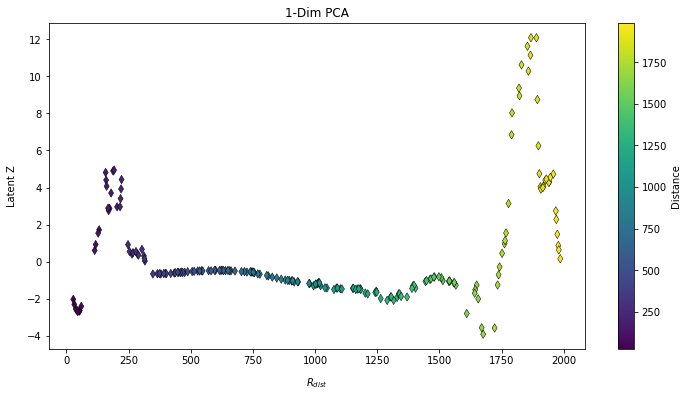

In [ ]:
pca_1 = PCA(n_components=1)
pca_train = pca_1.fit(X_train)
pca_1_z1 = pca_1.transform(X_test)

fig = plt.figure(figsize=(12,6))
#plt.scatter(Z_train_pca[:,0], Z_train_pca[:,1],c=color,label='train')

plt.scatter(test_color,pca_1_z1,c=test_color,marker="d",edgecolors='black',linewidths=0.5,label='test')
cbar = plt.colorbar()
cbar.set_label('Distance')
plt.xlabel('$R_{dist}$',labelpad=10)
plt.ylabel('Latent Z',labelpad=10)
plt.title('1-Dim PCA')
plt.savefig('/content/drive/MyDrive/data/images/pca_1_z.png')
#plt.legend(loc='best')
plt.show()

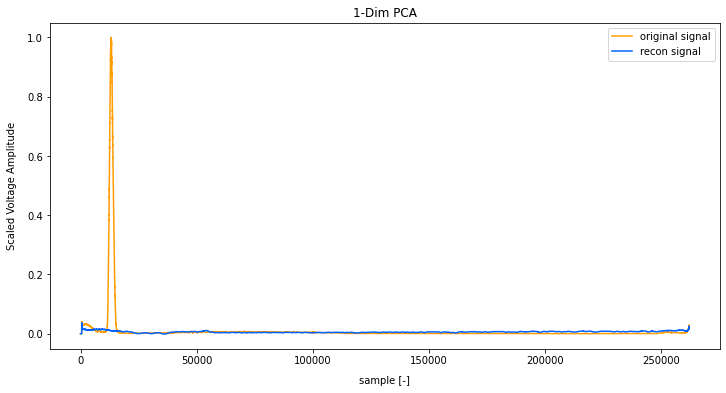

In [ ]:
plot_index = np.random.randint(0,100)
# Reconstructed PCA_1
pca_1_recon = pca_1.inverse_transform(pca_1_z1)


fig = plt.figure(figsize=(12,6))
plt.plot(X_test[plot_index],label='original signal',color='#FF9D01')
plt.plot(pca_1_recon[plot_index],label='recon signal',color='#0163FF')
plt.title('1-Dim PCA')
plt.xlabel('sample [-]',labelpad=10)
plt.ylabel('Scaled Voltage Amplitude',labelpad = 10)
#plt.xlim(0,1000)
# plt.ylim(0.45,0.55)
plt.legend(loc='best')

plt.savefig('/content/drive/MyDrive/data/images/pca_1_z_recon.png')
plt.show()

In [ ]:
#PCA 1 r2_score, explained_variance_score
pca1_mse = mean_squared_error(X_test,pca_1_recon)
ex_var_pca_1 = explained_variance_score(X_test,pca_1_recon)
print(f'pca_1_mse: {np.round(pca1_mse,3)}\npca_1_dim_explained_variance_score: {np.round(ex_var_pca_1,3)}')

pca_1_mse: 0.003
pca_1_dim_explained_variance_score: -0.094


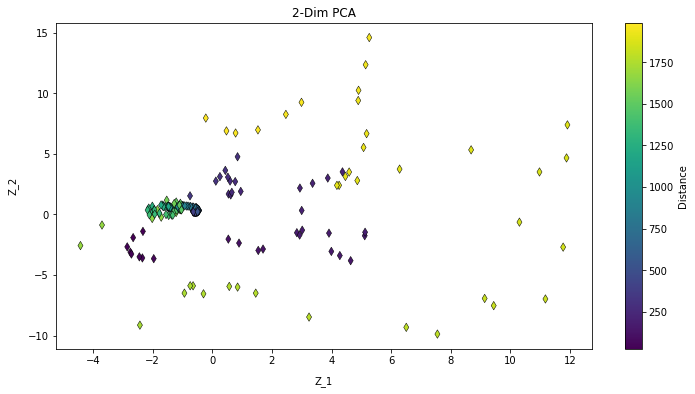

In [ ]:
# PCA 2 DIM
pca_2 = PCA(n_components=2)
pca_train = pca_2.fit(X_train)
pca_2_z2 = pca_2.transform(X_test)

fig = plt.figure(figsize=(12,6))
#plt.scatter(Z_train_pca[:,0], Z_train_pca[:,1],c=color,label='train')

plt.scatter(pca_2_z2[:,0],pca_2_z2[:,1],c=test_color,marker="d",edgecolors='black',linewidths=0.5,label='test')
cbar = plt.colorbar()
cbar.set_label('Distance')
plt.xlabel('Z_1',labelpad=10)
plt.ylabel('Z_2',labelpad=10)
plt.title('2-Dim PCA')
plt.savefig('/content/drive/MyDrive/data/images/pca_2_z.png')
#plt.legend(loc='best')
plt.show()

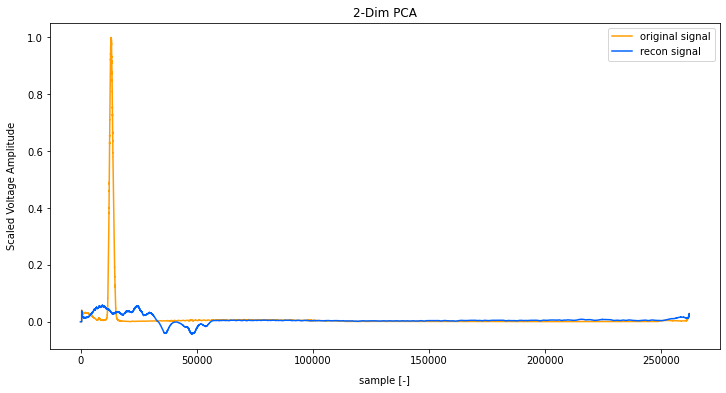

In [ ]:
# Reconstructed PCA_2
pca_2_recon = pca_2.inverse_transform(pca_2_z2)
#plot_index = np.random.randint(0,100)

fig = plt.figure(figsize=(12,6))
plt.plot(X_test[plot_index],label='original signal',color='#FF9D01')
plt.plot(pca_2_recon[plot_index],label='recon signal',color='#0163FF')
plt.title('2-Dim PCA')
plt.xlabel('sample [-]',labelpad=10)
plt.ylabel('Scaled Voltage Amplitude',labelpad = 10)
# plt.xlim(0,1000)
# plt.ylim(0.45,0.55)
plt.legend(loc='best')

plt.savefig('/content/drive/MyDrive/data/pca_2_z_recon.png')
plt.show()

In [ ]:
#PCA 2 r2_score, explained_variance_score
r2_score_pca_2 = r2_score(X_test,pca_2_recon)
ex_var_pca_2 = explained_variance_score(X_test,pca_2_recon)
print(f'pca_2_dim_r2_score: {np.round(r2_score_pca_2,3)}\npca_2_dim_explained_variance_score: {np.round(ex_var_pca_2,3)}')

pca_2_dim_r2_score: -0.521
pca_2_dim_explained_variance_score: -0.174


####ICA models with varying scalers

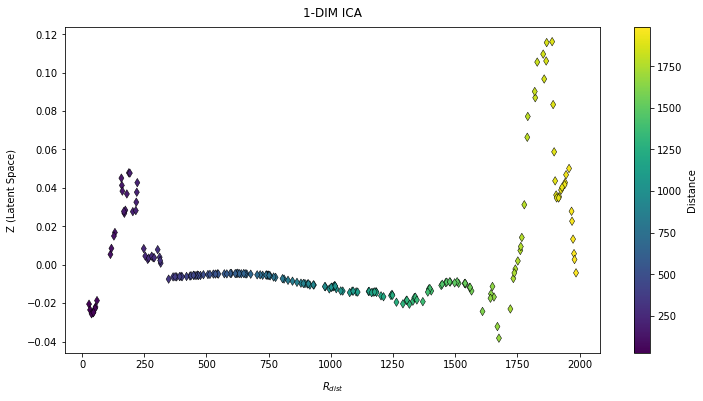

In [ ]:
# ICA 1-DIM
ica_1 = FastICA(n_components=1)
ica_1.fit(X_train)
ica_z_1 = ica_1.transform(X_test)
fig = plt.figure(figsize=(12,6))
plt.scatter(test_color,ica_z_1,marker="d",c=test_color,edgecolor='black',linewidths=0.5,label="test")
plt.title('1-DIM ICA',pad=10)
plt.xlabel('$R_{dist}$',labelpad=10)
plt.ylabel('Z (Latent Space)',labelpad=10)
cbar = plt.colorbar()
cbar.set_label('Distance')
# plt.legend(loc='best')
plt.savefig('/content/drive/MyDrive/data/images/ica_1_z.png')
plt.show()

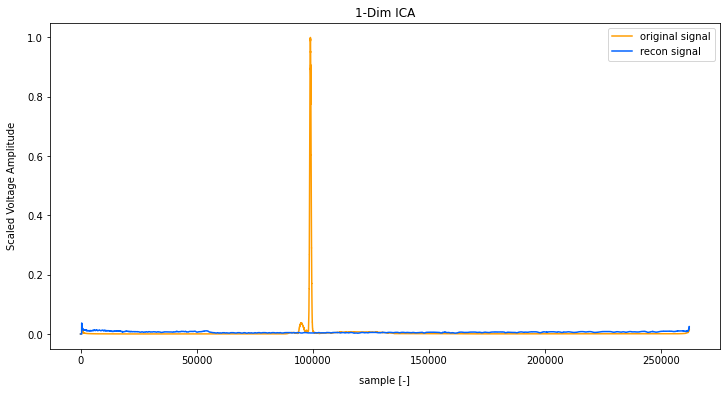

In [ ]:
# 1-DIM ICA recon
ica_1_recon = ica_1.inverse_transform(ica_z_1)
plot_index = np.random.randint(0,100)

fig = plt.figure(figsize=(12,6))
plt.plot(X_test[plot_index],label='original signal',color='#FF9D01')
plt.plot(ica_1_recon[plot_index],label='recon signal',color='#0163FF')
plt.title('1-Dim ICA')
plt.xlabel('sample [-]',labelpad=10)
plt.ylabel('Scaled Voltage Amplitude',labelpad = 10)
# plt.xlim(0,1000)
# plt.ylim(0.45,0.55)
plt.legend(loc='best')

plt.savefig('/content/drive/MyDrive/data/images/ica_1_z_recon.png')
plt.show()

In [ ]:
# 1-DIM ICA r2_score, explained_variance_score
r2_score_ica_1 = r2_score(X_test,ica_1_recon)
ex_var_ica_1 = explained_variance_score(X_test,ica_1_recon)
print(f'ica_1_dim_r2_score: {np.round(r2_score_ica_1,3)}\nica_1_dim_explained_variance_score: {np.round(ex_var_ica_1,3)}')

ica_1_dim_r2_score: -0.448
ica_1_dim_explained_variance_score: -0.101


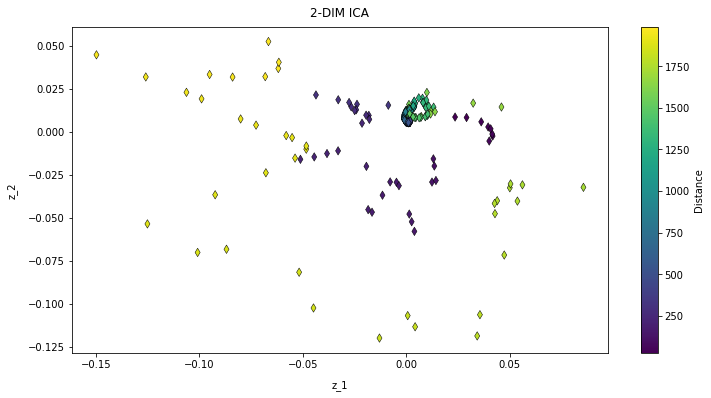

In [ ]:
# ICA 2-DIM
ica_2 = FastICA(n_components=2)
ica_2.fit(X_train)
ica_z_2 = ica_2.transform(X_test)
fig = plt.figure(figsize=(12,6))
plt.scatter(ica_z_2[:,0],ica_z_2[:,1],marker="d",c=test_color,edgecolor='black',linewidths=0.5,label="test")
plt.title('2-DIM ICA',pad=10)
plt.xlabel('z_1',labelpad=10)
plt.ylabel('z_2',labelpad=10)
cbar = plt.colorbar()
cbar.set_label('Distance')
# plt.legend(loc='best')
plt.savefig('/content/drive/MyDrive/data/images/ica_2_z.png')
plt.show()

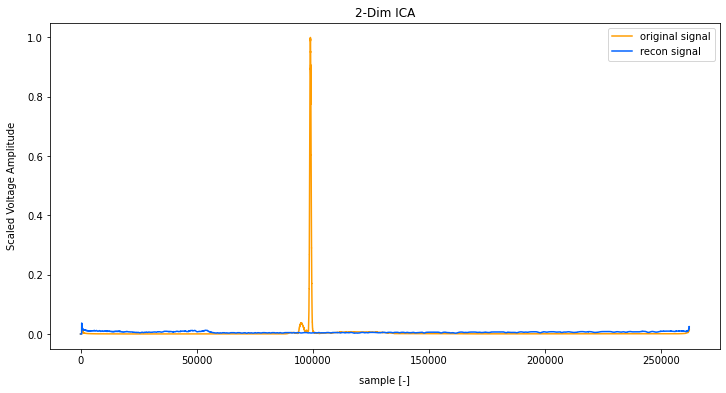

In [ ]:
# 2-DIM ICA recon
ica_2_recon = ica_2.inverse_transform(ica_z_2)
#plot_index = np.random.randint(0,100)

fig = plt.figure(figsize=(12,6))
plt.plot(X_test[plot_index],label='original signal',color='#FF9D01')
plt.plot(ica_2_recon[plot_index],label='recon signal',color='#0163FF')
plt.title('2-Dim ICA')
plt.xlabel('sample [-]',labelpad=10)
plt.ylabel('Scaled Voltage Amplitude',labelpad = 10)
# plt.xlim(0,1000)
# plt.ylim(0.45,0.55)
plt.legend(loc='best')
plt.savefig('/content/drive/MyDrive/data/images/ica_2_z_recon.png')
plt.show()


In [ ]:
# 1-DIM ICA r2_score, explained_variance_score
r2_score_ica_2 = r2_score(X_test,ica_2_recon)
ex_var_ica_2 = explained_variance_score(X_test,ica_2_recon)
print(f'ica_1_dim_r2_score: {np.round(r2_score_ica_2,3)}\nica_1_dim_explained_variance_score: {np.round(ex_var_ica_2,3)}')

ica_1_dim_r2_score: -0.519
ica_1_dim_explained_variance_score: -0.168


In [ ]:
#

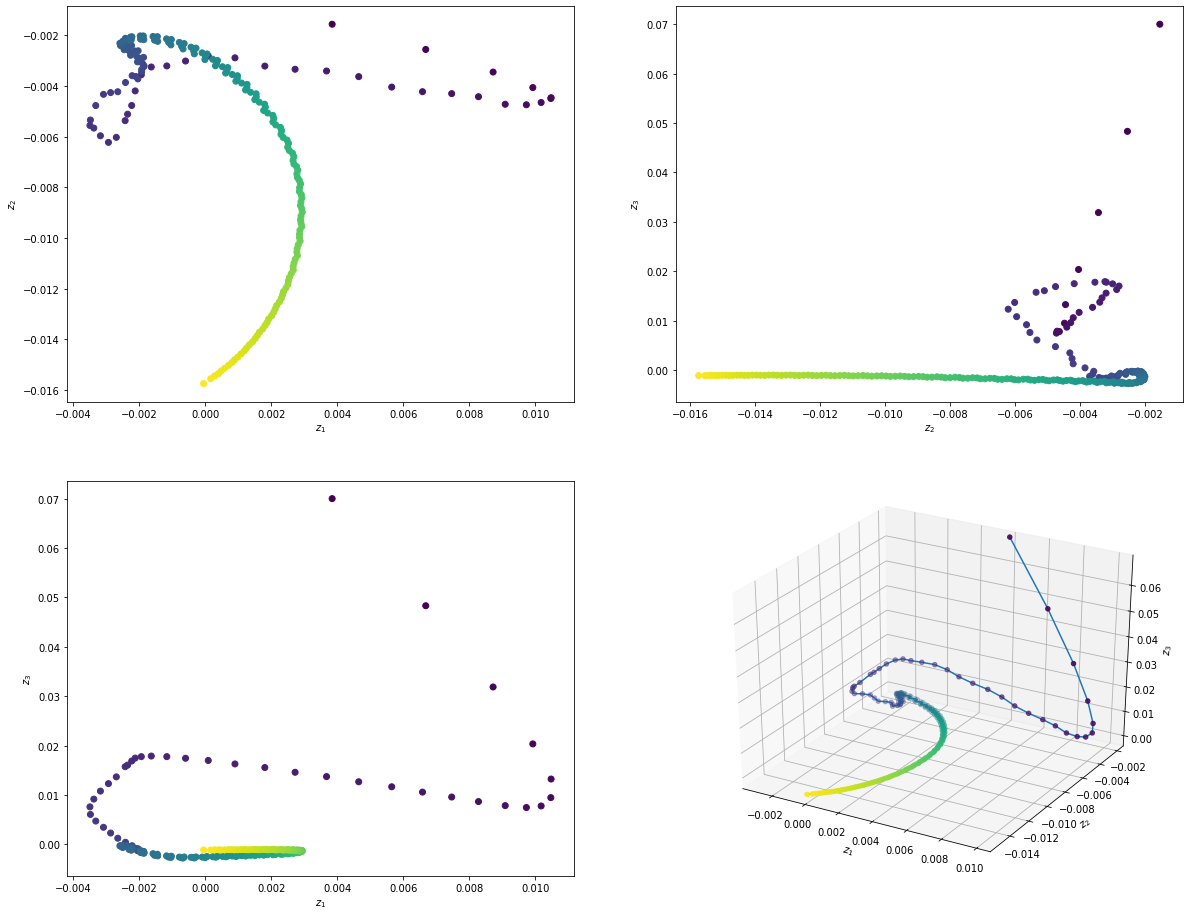

In [ ]:
# ICA 3-DIM

# ica_3 = FastICA(n_components=3)
# ica_3.fit(X_train)
# ica_z_3 = ica_3.transform(X_test)

fig = plt.figure(figsize=(20,16))

ax.set_title("3-DIM ICA", pad=10)
ax = fig.add_subplot(2,2,1)
ax.scatter(ica_z_3[:,0],ica_z_3[:,1],c=test_color)
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')

ax = fig.add_subplot(2,2,2)
ax.scatter(ica_z_3[:,1],ica_z_3[:,2],c=test_color)
ax.set_xlabel('$z_2$')
ax.set_ylabel('$z_3$')

ax = fig.add_subplot(2,2,3)
ax.scatter(ica_z_3[:,0],ica_z_3[:,2],c=test_color)
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_3$')

ax = fig.add_subplot(2,2,4, projection='3d')

ax.scatter(ica_z_3[:,0],ica_z_3[:,1],ica_z_3[:,2],c=test_color)
ax.plot3D(ica_z_3[:,0],ica_z_3[:,1],ica_z_3[:,2])
ax.margins(0)
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
ax.set_zlabel('$z_3$')



# fig.colorbar(color_test,ax=ax,orientation='vertical')

# fig = plt.figure(figsize=(12,8))
# ax = plt.axes(projection='3d')
# ax.scatter(ica_z_3[:,0],ica_z_3[:,1],ica_z_3[:,2],c=color2,linewidths=0.5,label="test");
# ax.set_title('3-DIM ICA',pad=10)
# ax.set_xlabel('Z_1',labelpad=10)
# ax.set_ylabel('Z_2',labelpad=10)
# ax.set_zlabel('Z_3',labelpad=10)
# # cbar = plt.colorbar()
# # cbar.set_label('Distance')
# # plt.legend(loc='best')
plt.savefig('/content/drive/MyDrive/data/images/ica_3_z.png')
plt.show()

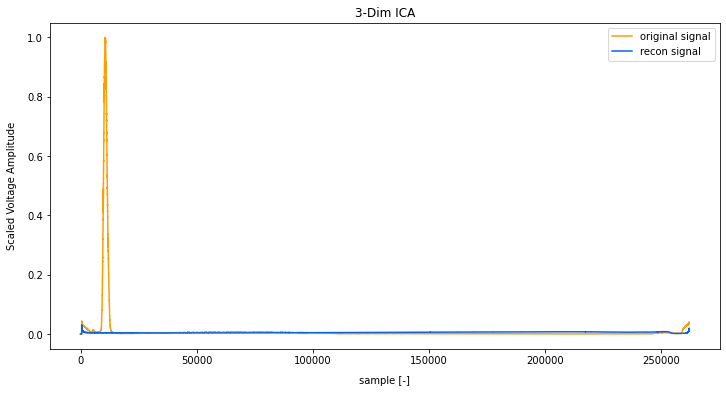

In [ ]:
# 3-DIM ICA recon
ica_3_recon = ica_3.inverse_transform(ica_z_3)
#plot_index = np.random.randint(0,100)

fig = plt.figure(figsize=(12,6))
plt.plot(X_test[plot_index],label='original signal',color='#FF9D01')
plt.plot(ica_3_recon[plot_index],label='recon signal',color='#0163FF')
plt.title('3-Dim ICA')
plt.xlabel('sample [-]',labelpad=10)
plt.ylabel('Scaled Voltage Amplitude',labelpad = 10)
# plt.xlim(0,1000)
# plt.ylim(0.45,0.55)
plt.legend(loc='best')
plt.savefig('/content/drive/MyDrive/data/ica_3_z_recon.png')
plt.show()

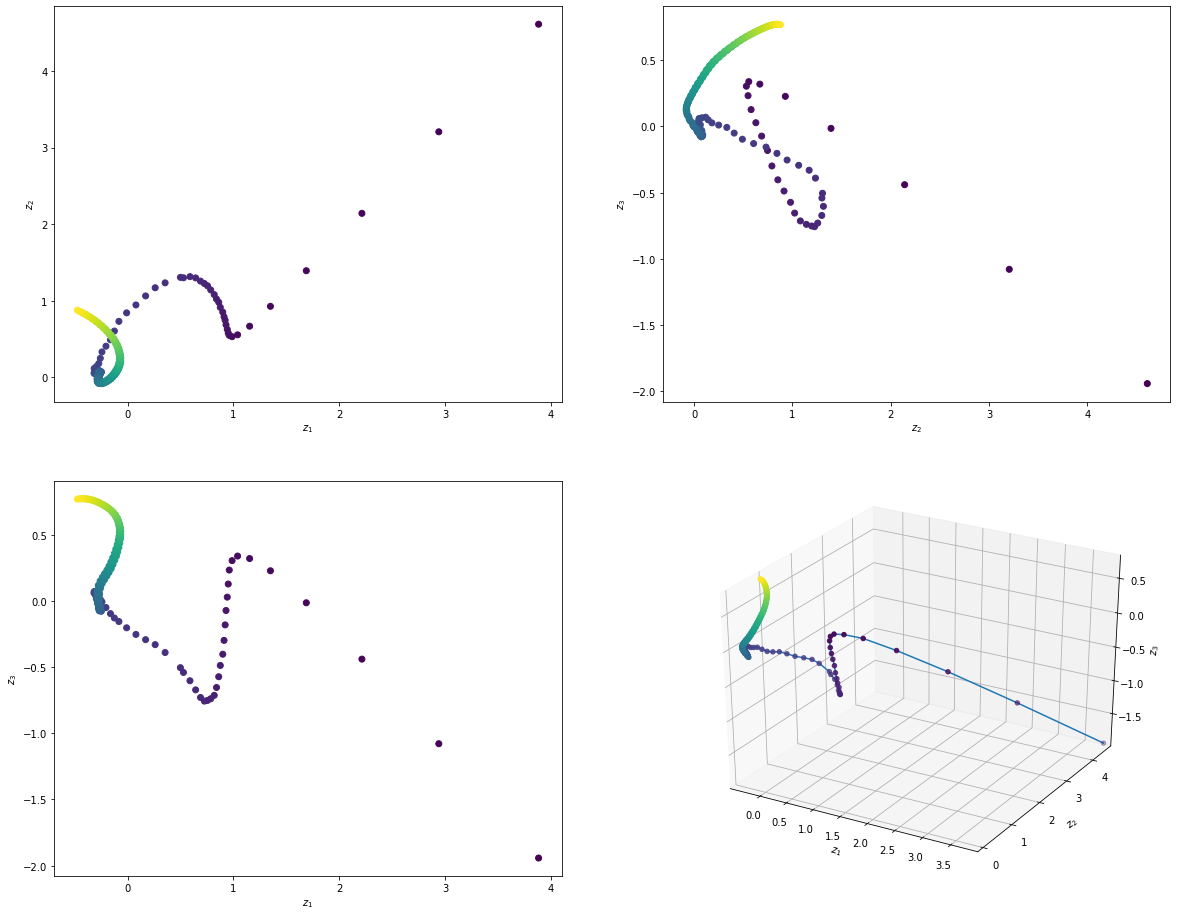

In [ ]:
# ICA 3-DIM

pca_3 = PCA(n_components=3)
pca_3.fit(X_train)
pca_z_3 = pca_3.transform(X_test)

fig = plt.figure(figsize=(20,16))

ax.set_title("3-DIM ICA", pad=10)
ax = fig.add_subplot(2,2,1)
ax.scatter(pca_z_3[:,0],pca_z_3[:,1],c=test_color)
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')

ax = fig.add_subplot(2,2,2)
ax.scatter(pca_z_3[:,1],pca_z_3[:,2],c=test_color)
ax.set_xlabel('$z_2$')
ax.set_ylabel('$z_3$')

ax = fig.add_subplot(2,2,3)
ax.scatter(pca_z_3[:,0],pca_z_3[:,2],c=test_color)
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_3$')

ax = fig.add_subplot(2,2,4, projection='3d')

ax.scatter(pca_z_3[:,0],pca_z_3[:,1],pca_z_3[:,2],c=test_color)
ax.plot3D(pca_z_3[:,0],pca_z_3[:,1],pca_z_3[:,2])
ax.margins(0)
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
ax.set_zlabel('$z_3$')



# fig.colorbar(color_test,ax=ax,orientation='vertical')

# fig = plt.figure(figsize=(12,8))
# ax = plt.axes(projection='3d')
# ax.scatter(ica_z_3[:,0],ica_z_3[:,1],ica_z_3[:,2],c=color2,linewidths=0.5,label="test");
# ax.set_title('3-DIM ICA',pad=10)
# ax.set_xlabel('Z_1',labelpad=10)
# ax.set_ylabel('Z_2',labelpad=10)
# ax.set_zlabel('Z_3',labelpad=10)
# # cbar = plt.colorbar()
# # cbar.set_label('Distance')
# # plt.legend(loc='best')
plt.savefig('/content/drive/MyDrive/data/images/pca_3_z.png')
plt.show()

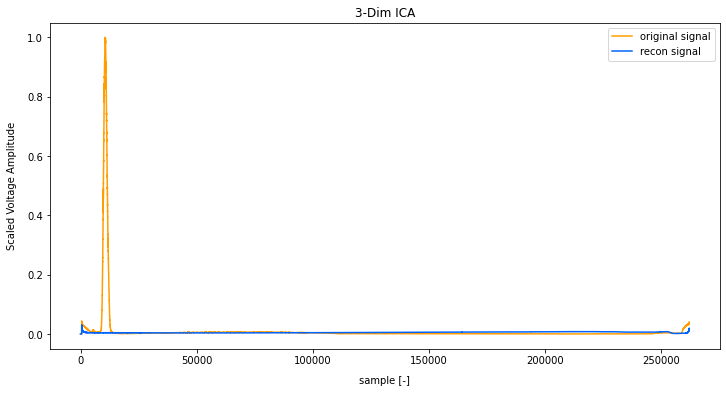

In [ ]:
# 3-DIM ICA recon
pca_3_recon = pca_3.inverse_transform(pca_z_3)
#plot_index = np.random.randint(0,100)

fig = plt.figure(figsize=(12,6))
plt.plot(X_test[plot_index],label='original signal',color='#FF9D01')
plt.plot(pca_3_recon[plot_index],label='recon signal',color='#0163FF')
plt.title('3-Dim ICA')
plt.xlabel('sample [-]',labelpad=10)
plt.ylabel('Scaled Voltage Amplitude',labelpad = 10)
# plt.xlim(0,1000)
# plt.ylim(0.45,0.55)
plt.legend(loc='best')
plt.savefig('/content/drive/MyDrive/data/pca_3_z_recon.png')
plt.show()

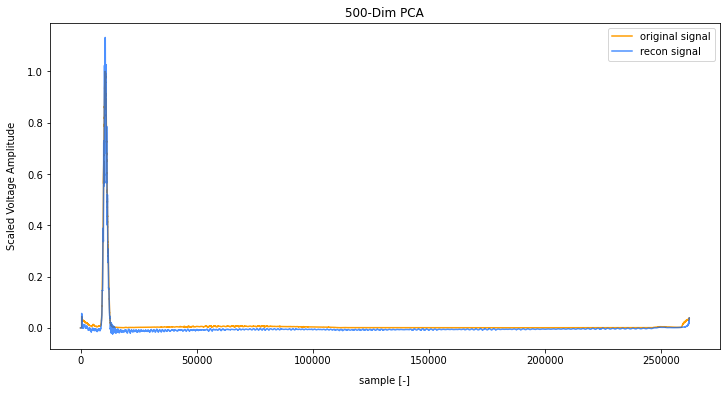

In [ ]:
# pca_8 = PCA(n_components=300)
# pca_8.fit(X_train)
# pca_z_8 = pca_8.transform(X_test)
# pca_8_recon = pca_8.inverse_transform(pca_z_8)
#plot_index = np.random.randint(0,100)

fig = plt.figure(figsize=(12,6))
plt.plot(X_test[plot_index],label='original signal',color='#FF9D01')
plt.plot(pca_8_recon[plot_index],label='recon signal',color='#0163FF',alpha=0.7)
plt.title('500-Dim PCA')
plt.xlabel('sample [-]',labelpad=10)
plt.ylabel('Scaled Voltage Amplitude',labelpad = 10)
# plt.xlim(0,1000)
# plt.ylim(0.45,0.55)
plt.legend(loc='best')
plt.savefig('/content/drive/MyDrive/data/images/pca_300_z_recon.png')
plt.show()

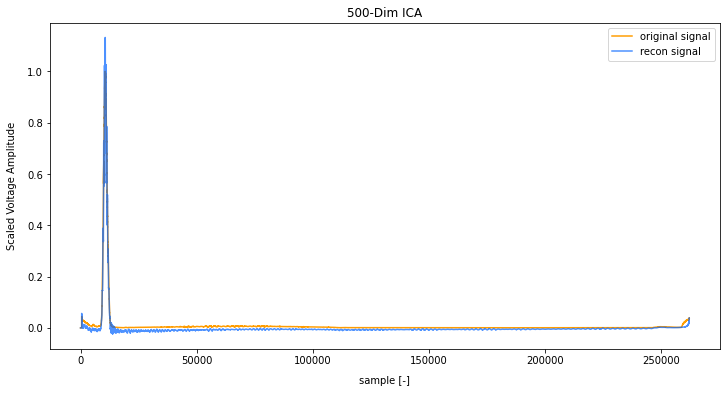

In [ ]:
# pca_8 = FastICA(n_components=250)
# pca_8.fit(X_train)
# pca_z_8 = pca_8.transform(X_test)
# pca_8_recon = pca_8.inverse_transform(pca_z_8)
#plot_index = np.random.randint(0,100)

fig = plt.figure(figsize=(12,6))
plt.plot(X_test[plot_index],label='original signal',color='#FF9D01')
plt.plot(pca_8_recon[plot_index],label='recon signal',color='#0163FF',alpha=0.7)
plt.title('500-Dim ICA')
plt.xlabel('sample [-]',labelpad=10)
plt.ylabel('Scaled Voltage Amplitude',labelpad = 10)
# plt.xlim(0,1000)
# plt.ylim(0.45,0.55)
plt.legend(loc='best')
plt.savefig('/content/drive/MyDrive/data/images/ica_250_z_recon.png')
plt.show()

###AutoEncoder

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#dt.shape
X_train.shape

(900, 262144)

In [ ]:
encoder = keras.models.Sequential([keras.layers.Dense(2,input_shape=[X_train.shape[1]])])
decoder = keras.models.Sequential([keras.layers.Dense(X_train.shape[1],input_shape=[2])])

autoencoder = keras.models.Sequential([encoder,decoder])

In [ ]:
encoder = keras.Sequential([
                            layers.Input(shape=(X_train[1],X_train[2]),),

                            layers.Conv1D(filters=16,kernel_size=5,padding='same',strides=100,activation='relu'),

                            layers.Conv1D(filters=8,kernel_size=5,padding='same',strides=100,activation='relu'),

                            layers.BatchNormalization(),

                            layers.Dense(latent_dim,name='mu_layer'),

                            layers.Dense(latent_dim,name='sigma_layer'),

                            
                            
])

In [ ]:
autoencoder.compile(loss='mse',optimizer=keras.optimizers.Adam(learning_rate=0.0005))

In [ ]:
training = autoencoder.fit(X_train,X_train, epochs=50)

Train on 900 samples
Epoch 1/50
900/900 [==============================] - 2s 2ms/sample - loss: 0.0844
Epoch 2/50
900/900 [==============================] - 2s 2ms/sample - loss: 0.0017
Epoch 3/50
900/900 [==============================] - 2s 2ms/sample - loss: 6.1743e-04
Epoch 4/50
900/900 [==============================] - 2s 2ms/sample - loss: 8.9011e-04
Epoch 5/50
900/900 [==============================] - 2s 2ms/sample - loss: 6.3987e-04
Epoch 6/50
900/900 [==============================] - 2s 2ms/sample - loss: 3.6465e-04
Epoch 7/50
900/900 [==============================] - 2s 2ms/sample - loss: 0.0010
Epoch 8/50
900/900 [==============================] - 2s 2ms/sample - loss: 5.0542e-04
Epoch 9/50
900/900 [==============================] - 2s 2ms/sample - loss: 3.5584e-04
Epoch 10/50
900/900 [==============================] - 2s 2ms/sample - loss: 4.0702e-04
Epoch 11/50
900/900 [==============================] - 2s 2ms/sample - loss: 0.0011
Epoch 12/50
900/900 [===============

In [ ]:
p = autoencoder.predict(X_test)

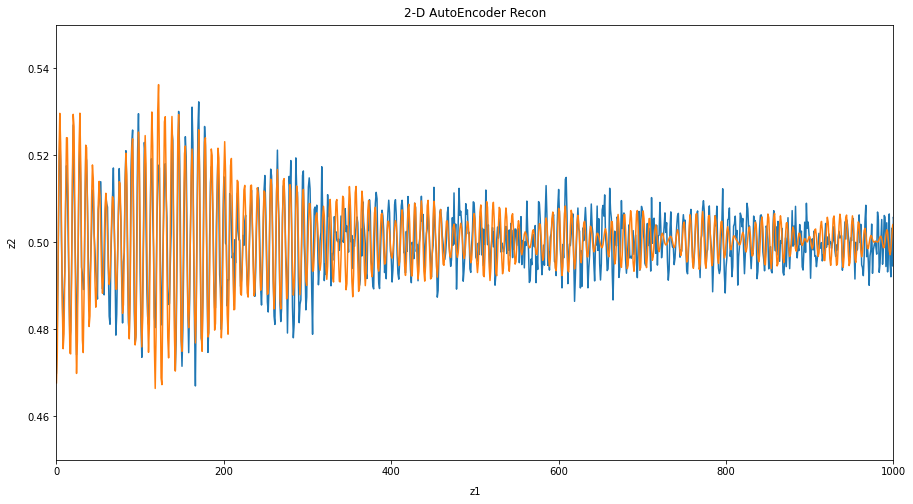

In [ ]:
fig = plt.figure(figsize=(15,8))
plt.plot(p[plot_index])
plt.plot(X_test[plot_index])
plt.xlim(0,1000)
plt.ylim(0.45,0.55)
plt.title('2-D AutoEncoder Recon',pad=8)
cbar.set_label('Distance')
plt.xlabel('z1',labelpad=10)
plt.ylabel('z2',labelpad=10)
plt.savefig('/content/drive/MyDrive/data/2_d_autoencoder_recon.png')

###Latent Space Visualization of Autoencoder

In [ ]:
latent = encoder.predict(X_train)
# X_n = []
# i=0
# for i in range(0,X_test.shape[0]):     #i-th sample
#   temp = []
#   for j in range(1,X_test.shape[1]):   #j-th element of sample i
#     temp.append(np.float(np.sin((np.pi/2)*np.random.rand(1))*1e-1))     # adding noise to the test sample
#     j+=1
#   temp.insert(0,X_test[i][0])
#   i+=1
  
#   X_n.append(temp)
  
latent_test = encoder.predict(X_test)

In [ ]:
latent_test.shape

(100, 2)

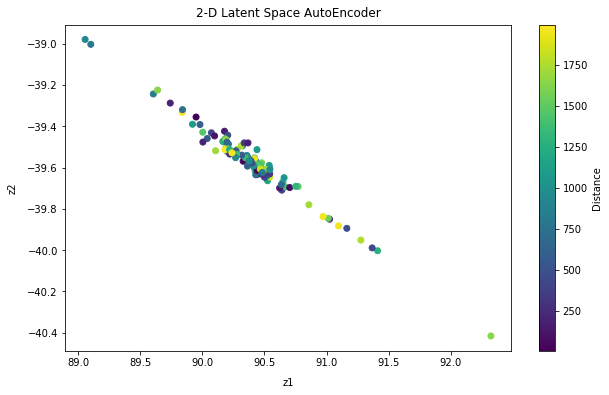

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.scatter(latent_test[:,0],latent_test[:,1],c=color2)
#plt.scatter(latent_test[:,0],latent_test[:,1],c=color2)
cbar = plt.colorbar()
plt.title('2-D Latent Space AutoEncoder',pad=8)
cbar.set_label('Distance')
plt.xlabel('z1',labelpad=10)
plt.ylabel('z2',labelpad=10)
plt.savefig('/content/drive/MyDrive/data/2_dautoencoder_latent.png')
plt.show()

##### Callback for earlystop during training basaed on error

In [ ]:
from functools import partial
# import tensorflow.compat.v1 as tf
# import tensorflow.keras.layers as K
# from keras.layer import Layer, add_as_function

# @add_as_function
class Conv1DTranspose:
    """ Transposed 1D convolution layer.

    Parameters
    ----------
    filters : int
        Number of filters in the ouput tensor.
    kernel_size : int
        Kernel size.
    strides : int
        Convolution stride. Default is 1.
    """
    def __init__(self, filters, kernel_size, strides=1, padding='valid', data_format='channels_last', *args, **kwargs):
        self.filters, self.kernel_size, self.strides = filters, kernel_size, strides
        self.padding, self.data_format = padding, data_format
        self.args, self.kwargs = args, kwargs

    def __call__(self, inputs):
        axis = 1 if self.data_format == 'channels_last' else 2
        x = tf.expand_dims(inputs, axis=axis)
        x = tf.keras.layers.Conv2DTranspose(filters=self.filters, kernel_size=(1, self.kernel_size),
                              strides=(1, self.strides), padding=self.padding, **self.kwargs)(x)
        x = tf.squeeze(x, [axis])
        return x

Conv1DTranspose( filters=16,kernel_size=4096,strides=1024,activation='relu',padding='same')

In [ ]:
#from Isaac call
es = keras.callbacks.EarlyStopping(monitor='loss',patience=50,verbose=1, mode='auto',baseline=None)
model_checkpoint_filepath = '/content/drive/MyDrive/data/vae_model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_checkpoint_filepath,
                                                               save_weights_only=True,
                                                               monitor='loss',
                                                               mode='auto',
                                                               save_best_only=True)

In [ ]:
# Y = dt
# X_train, X_test = train_test_split(Y,test_size=0.1);

# X_val = X_train[800:]
X_train = np.reshape(X_train,newshape=(100,262144,1))
# X_test = np.reshape(X_test,newshape=(225,262144,1,))
# X_test = tf.convert_to_tensor(X_test)

In [ ]:
X_val = np.reshape(X_val,newshape=(100,262144,1,))
# X_val = tf.convert_to_tensor(X_val)

#### VAE

In [ ]:
class B_VAE():

  # class Conv1DTranspose:
  #   """ Transposed 1D convolution layer.

  #   Parameters
  #   ----------
  #   filters : int
  #       Number of filters in the ouput tensor.
  #   kernel_size : int
  #       Kernel size.
  #   strides : int
  #       Convolution stride. Default is 1.
  #   """
  #   def __init__(self, filters, kernel_size, strides=1, padding='valid', data_format='channels_last', *args, **kwargs):
  #       self.filters, self.kernel_size, self.strides = filters, kernel_size, strides
  #       self.padding, self.data_format = padding, data_format
  #       self.args, self.kwargs = args, kwargs

  #   def __call__(self, inputs):
  #       axis = 1 if self.data_format == 'channels_last' else 2
  #       x = tf.expand_dims(inputs, axis=axis)
  #       x = tf.keras.layers.Conv2DTranspose(filters=self.filters, kernel_size=(1, self.kernel_size),
  #                             strides=(1, self.strides), padding=self.padding, **self.kwargs)(x)
  #       x = tf.squeeze(x, [axis])
  #       return x

  def __init__(self,name,inputs,test_batch,alpha,beta,epochs,val_data,batch_size,latent_dim):
    
    self.name = name
    self.inputs = inputs
    self.test_batch = test_batch
    self.alpha = alpha
    self.beta = beta
    self.epochs = epochs
    self.val_data = val_data
    self.latent_dim = latent_dim
    self.batch_size = batch_size

  def train(self):

    def Sampling(a):

      mu, sigma = a
      batch_size = tf.keras.backend.shape(mu)[0]
      dim = tf.keras.backend.int_shape(mu)[1]
      epsilon = tf.keras.backend.random_normal(shape=(batch_size,dim))
      return mu+epsilon*tf.math.exp(0.5*sigma)

    alpha = self.alpha
    latent_dim = self.latent_dim

    global batch
   
    inputs = tf.keras.Input(shape=(262144,1,))

    encode = tf.keras.layers.Conv1D(filters=8,kernel_size=257,activation='relu',padding='same',strides=64,name='enc-1')(inputs)

    # encode = tf.keras.layers.MaxPooling1D(pool_size=65,strides=16,padding='same')(encode)

    #encode = tf.keras.layers.Conv1D(filters=4 , kernel_size = 129,activation='relu',padding='same',strides=4,name='enc-2')(encode)

    encode = tf.keras.layers.BatchNormalization()(encode)

    batch = tf.keras.layers.Conv1D(filters=16 , kernel_size = 3,activation='relu',padding='same',strides=2, name='batch')(encode)

    enccode = tf.keras.layers.BatchNormalization()(batch)

    encode = tf.keras.layers.Flatten()(encode)

    encode = tf.keras.layers.Dense(2,activation='relu',kernel_regularizer='l2',name='dense-1')(encode)

    encode = tf.keras.layers.BatchNormalization()(encode)



    mu = tf.keras.layers.Dense(latent_dim,name='mu_layer')(encode)
    sigma = tf.keras.layers.Dense(latent_dim,name='sigma_layer')(encode)

    global z

    before_lambda = tf.keras.models.Model(inputs,encode,name='before_lambda')

    z = tf.keras.layers.Lambda(Sampling,output_shape=(latent_dim,), name='z_sample_layer')([mu,sigma])

    global after_lambda

    after_lambda = tf.keras.models.Model(inputs,z,name='after_lambda')

    units = batch.shape[1]*batch.shape[2]

    decode = tf.keras.layers.Dense(units,activation='relu',name='dec-4',kernel_regularizer='l2')(after_lambda.output)

    decode = tf.keras.layers.Reshape((batch.shape[1], batch.shape[2]), name="decode_reshape")(decode)

    decode = tf.keras.layers.BatchNormalization()(decode)
    
    decode = Conv1DTranspose(filters=16,kernel_size = 3, strides=2, activation='relu',padding='same',name='dec-3')(decode)
    
    decode = tf.keras.layers.BatchNormalization()(decode)

    # decode = Conv1DTranspose(filters=4,kernel_size = 129, strides=4, activation='relu',padding='same',name='dec-2')(decode)

    decode = Conv1DTranspose(filters=8,kernel_size = 257, strides=64, activation='relu',padding='same',name='dec-1')(decode)

    decode = tf.keras.layers.BatchNormalization()(decode)
    
    outputs = Conv1DTranspose(filters=1,kernel_size = 257, strides=1, activation='sigmoid',padding='same',name='dec-output')(decode)

    global vae

    vae = tf.keras.Model(inputs=inputs, outputs=outputs)

    # def encoder_model(self):
    #   encoder = tf.keras.Model(inputs=self.inputs, outputs=[mu,sigma,z],name='enc_model')
    #   return encoder

    def recon_loss(input_sig,output_sig):

      recon_loss = tf.keras.losses.mean_squared_error(input_sig,output_sig)

      return recon_loss

    def kld_loss(mu,sigma):
      
      kl_loss = -0.5*tf.reduce_mean(1+sigma-tf.keras.backend.square(mu)-
                                          tf.math.exp(sigma))
      return kl_loss


    def vae_loss(input_sig,output_sig):

      total_loss = self.beta*kld_loss(mu,sigma)+recon_loss(input_sig,output_sig)

      return tf.reduce_mean(total_loss)

    initial_learning_rate = 5e-3
    final_learning_rate = 5e-6
    learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/self.epochs)
    
    steps_per_epoch = 1

    lr_schedule = ExponentialDecay(
                    initial_learning_rate=initial_learning_rate,
                    decay_steps=200,
                    decay_rate=5e-6,
                    staircase=True)


    #lr_scheduler = PolynomialDecay(initial_learning_rate=0.00001,end_learning_rate=0.0000001,decay_steps=100000,power=1)
    optimizer = tf.keras.optimizers.Adam(learning_rate = 8e-5)
    vae.compile(optimizer=optimizer,loss=vae_loss,run_eagerly=0)


    inputs = self.inputs.reshape((-1,262144,1,))
    val_data = self.val_data.reshape((-1,262144,1,))

    global results
    

    # results = vae.fit(inputs,inputs,epochs=self.epochs,batch_size=self.batch_size,validation_data=(val_data,val_data),callbacks=[model_checkpoint_callback,es]);
    results = vae.fit(inputs,inputs,epochs=self.epochs,batch_size=self.batch_size,callbacks=[model_checkpoint_callback]);
  
  # def latent_space(self):
  #     return z

  def predict(self,test_batch):

    index = 0
    test_batch = test_batch.reshape((-1,262144,1,))
    # index = np.random.randint(0,test_batch.shape[0])
    p = vae.predict(test_batch)
    fig = plt.figure(figsize=(15,8))
    
    plt.plot(p[index],label='recon_signal',color='#FF9D01',alpha=0.6)
    plt.plot(test_batch[index],label='original_signal',color='#0163FF',alpha=0.4)
    plt.title(f'B-VAE Prediction \u03B2={self.beta}',pad=10)
    plt.xlabel('Sample point',labelpad=10)
    plt.ylabel('Scaled Voltage Amplitude',labelpad=10)
    plt.legend(loc='best')
    # plt.xlim(0,1000)
    # plt.ylim(-0.00003,0.00003)
    plt.savefig(fname=f'/content/drive/MyDrive/data/images/beta_{self.beta}_recon.PNG')
    plt.show()


    return p

  def loss_results(self):
    return results.history['loss']

  def latent_pred(self,test_batch):


    test_batch = self.test_batch.reshape((-1,262144,1,))

    
    z_space = after_lambda.predict(test_batch)

    print(z_space.shape)

    if self.latent_dim==1:
      
      fig =plt.figure(figsize=(10,6))
      plt.scatter(test_color,z_space,c=test_color,marker='d',edgecolors='black',linewidths=0.5)
      plt.xlabel('$R_{dist}$',labelpad=10)
      plt.ylabel('z1',labelpad=10)
      cbar = plt.colorbar()
      cbar.set_label('Distance')
      plt.title(f'B-VAE Representation \u03B2={self.beta}',pad=10)
      plt.savefig(fname=f'/content/drive/MyDrive/data/images/beta_{self.beta}_latent_z1.PNG')
      plt.show()


    if self.latent_dim==2:
      fig =plt.figure(figsize=(10,6))
      plt.scatter(z_space[:,0],z_space[:,1],c=test_color,marker='d',edgecolors='black',linewidths=0.5)
      plt.xlabel('z1',labelpad=10)
      plt.ylabel('z2',labelpad=10)
      cbar = plt.colorbar()
      cbar.set_label('Distance')
      plt.title(f'B-VAE Representation \u03B2={self.beta}',pad=10)
      plt.savefig(fname=f'/content/drive/MyDrive/data/images/beta_{self.beta}_latent_z2.PNG')
      plt.show()


    if self.latent_dim==3:

      fig = plt.figure(figsize=(25,18))

      ax = fig.add_subplot(2,2,1)
      ax.scatter(z_space[:,0],z_space[:,1],c=test_color)
      ax.set_xlabel('$z_1$')
      ax.set_ylabel('$z_2$')

      ax = fig.add_subplot(2,2,2)
      ax.scatter(z_space[:,1],z_space[:,2],c=test_color)
      ax.set_xlabel('$z_2$')
      ax.set_ylabel('$z_3$')

      ax = fig.add_subplot(2,2,3)
      ax.scatter(z_space[:,0],z_space[:,2],c=test_color)
      ax.set_xlabel('$z_1$')
      ax.set_ylabel('$z_3$')

      ax = fig.add_subplot(2,2,4, projection='3d')

      ax.scatter(z_space[:,0],z_space[:,1],z_space[:,2],c=test_color)
      ax.plot3D(z_space[:,0],z_space[:,1],z_space[:,2],alpha=0.4)
      ax.margins(0)
      ax.set_xlabel('$z_1$')
      ax.set_ylabel('$z_2$')
      ax.set_zlabel('$z_3$')

      plt.savefig(fname=f'/content/drive/MyDrive/data/images/beta_{self.beta}_latent_z3.PNG',dpi=150)



    return z_space


  def summary(self):

    return vae.summary()


  def save_model(self):
    return





....................|.....................................$\beta$......................................|                          
$epochs$......|......**1**......|.......**2**......|......**3**......|.......**4**......|.......**5**......|\
.......**100**......|....$l_{11}$.....|.....$l_{12}$.....|.....$l_{13}$....|.....$l_{14}$.....|......$l_{15}$.....|\
.......**200**......|....$l_{21}$.....|.....$l_{22}$.....|.....$l_{23}$....|.....$l_{24}$.....|......$l_{25}$.....|\
.......**300**......|....$l_{31}$.....|.....$l_{32}$.....|.....$l_{33}$....|.....$l_{34}$.....|......$l_{35}$.....|\
.......**400**......|....$l_{41}$.....|.....$l_{42}$.....|.....$l_{43}$....|.....$l_{44}$.....|......$l_{45}$.....|\
.......**500**......|....$l_{51}$.....|.....$l_{52}$.....|.....$l_{53}$....|.....$l_{54}$.....|......$l_{55}$.....|

In [ ]:
var_dict = {}

for i in range(100,50100,100):

  for j in range(1,101):

    x = f'e{int(i/100)}_b{j}' 
    y = B_VAE(name=x,inputs=X_train[:100],test_batch=X_test,val_data=X_val[:20],alpha=0.4,batch_size=100,beta=j,epochs=int(i),latent_dim=1)  
    var_dict[x]=y

    j+=1

Train on 100 samples
Epoch 1/1000
100/100 [==============================] - 15s 148ms/sample - loss: 2.4035
Epoch 2/1000
100/100 [==============================] - 0s 5ms/sample - loss: 2.1866
Epoch 3/1000
100/100 [==============================] - 0s 5ms/sample - loss: 2.0365
Epoch 4/1000
100/100 [==============================] - 0s 5ms/sample - loss: 1.9177
Epoch 5/1000
100/100 [==============================] - 0s 5ms/sample - loss: 1.8176
Epoch 6/1000
100/100 [==============================] - 0s 5ms/sample - loss: 1.7256
Epoch 7/1000
100/100 [==============================] - 0s 5ms/sample - loss: 1.6407
Epoch 8/1000
100/100 [==============================] - 0s 5ms/sample - loss: 1.5656
Epoch 9/1000
100/100 [==============================] - 0s 5ms/sample - loss: 1.5004
Epoch 10/1000
100/100 [==============================] - 0s 5ms/sample - loss: 1.4381
Epoch 11/1000
100/100 [==============================] - 0s 5ms/sample - loss: 1.3803
Epoch 12/1000
100/100 [================

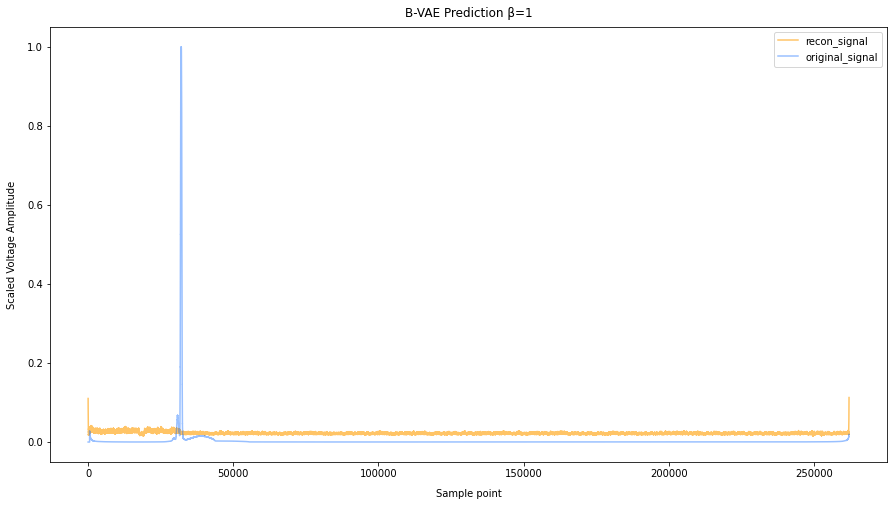

(300, 1)


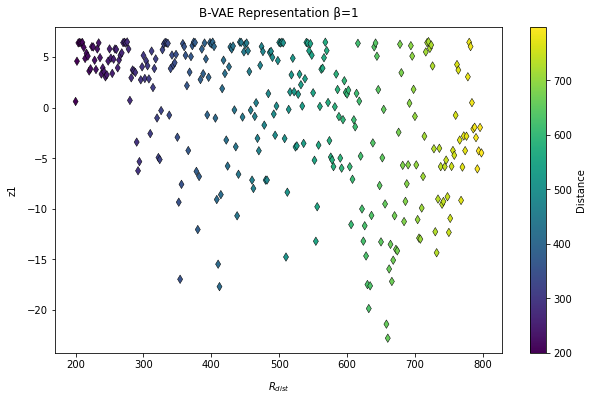

In [ ]:
n = 'e10_b1'
var_dict[n].train()
n_recon = var_dict[n].predict(X_test)
n_latent_z = var_dict[n].latent_pred(X_test)

Train on 100 samples
Epoch 1/1000
100/100 [==============================] - 2s 18ms/sample - loss: 2.5122
Epoch 2/1000
100/100 [==============================] - 0s 5ms/sample - loss: 2.2442
Epoch 3/1000
100/100 [==============================] - 0s 5ms/sample - loss: 1.7882
Epoch 4/1000
100/100 [==============================] - 0s 5ms/sample - loss: 1.6660
Epoch 5/1000
100/100 [==============================] - 0s 5ms/sample - loss: 1.6036
Epoch 6/1000
100/100 [==============================] - 0s 5ms/sample - loss: 1.5589
Epoch 7/1000
100/100 [==============================] - 0s 5ms/sample - loss: 1.5294
Epoch 8/1000
100/100 [==============================] - 0s 5ms/sample - loss: 1.4754
Epoch 9/1000
100/100 [==============================] - 0s 5ms/sample - loss: 1.4215
Epoch 10/1000
100/100 [==============================] - 0s 5ms/sample - loss: 1.3715
Epoch 11/1000
100/100 [==============================] - 0s 5ms/sample - loss: 1.3209
Epoch 12/1000
100/100 [==================

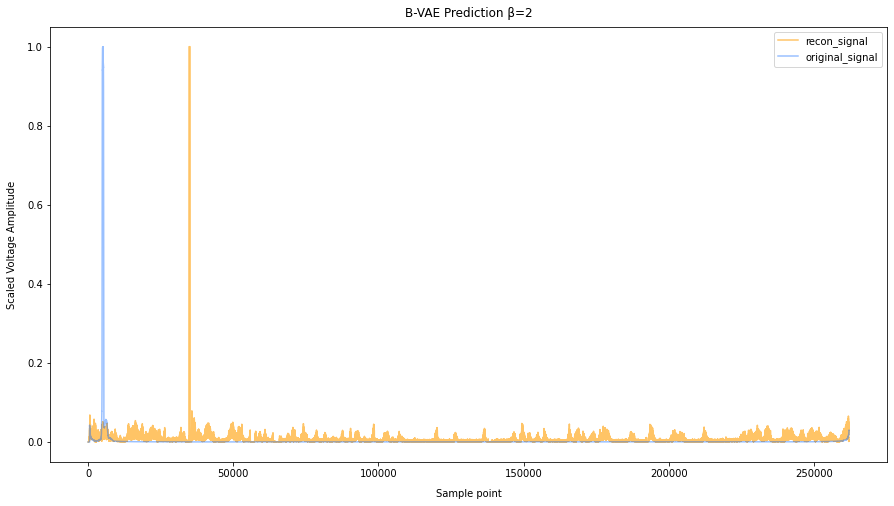

(225, 2)


<Figure size 432x288 with 0 Axes>

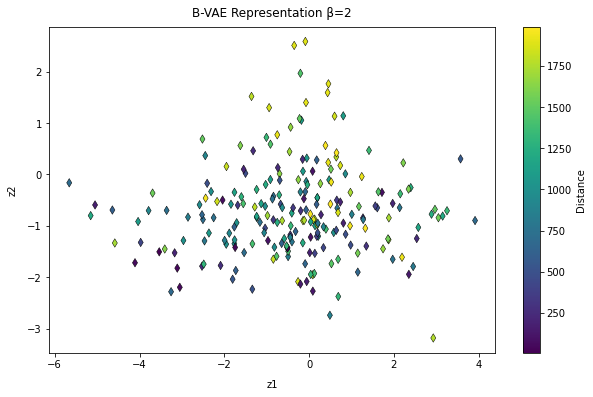

In [ ]:
n = 'e10_b2'
var_dict[n].train()
n_recon = var_dict[n].predict(X_test)
n_latent_z = var_dict[n].latent_pred(X_test)

In [ ]:

# y_pred.shape
# y_true= np.reshape(X_test, newshape=(255,262144))
#y_pred= np.reshape(n_recon, newshape=(255,262144))

r2_score(X_test,y_pred)

-0.4586863529717026

Train on 100 samples
Epoch 1/1000
100/100 [==============================] - 15s 150ms/sample - loss: 1.8868
Epoch 2/1000
100/100 [==============================] - 0s 5ms/sample - loss: 1.8274
Epoch 3/1000
100/100 [==============================] - 0s 5ms/sample - loss: 1.7697
Epoch 4/1000
100/100 [==============================] - 0s 5ms/sample - loss: 1.7114
Epoch 5/1000
100/100 [==============================] - 0s 5ms/sample - loss: 1.6588
Epoch 6/1000
100/100 [==============================] - 0s 5ms/sample - loss: 1.6047
Epoch 7/1000
100/100 [==============================] - 0s 5ms/sample - loss: 1.5559
Epoch 8/1000
100/100 [==============================] - 0s 5ms/sample - loss: 1.5107
Epoch 9/1000
100/100 [==============================] - 0s 5ms/sample - loss: 1.4660
Epoch 10/1000
100/100 [==============================] - 0s 5ms/sample - loss: 1.4256
Epoch 11/1000
100/100 [==============================] - 0s 5ms/sample - loss: 1.3816
Epoch 12/1000
100/100 [================

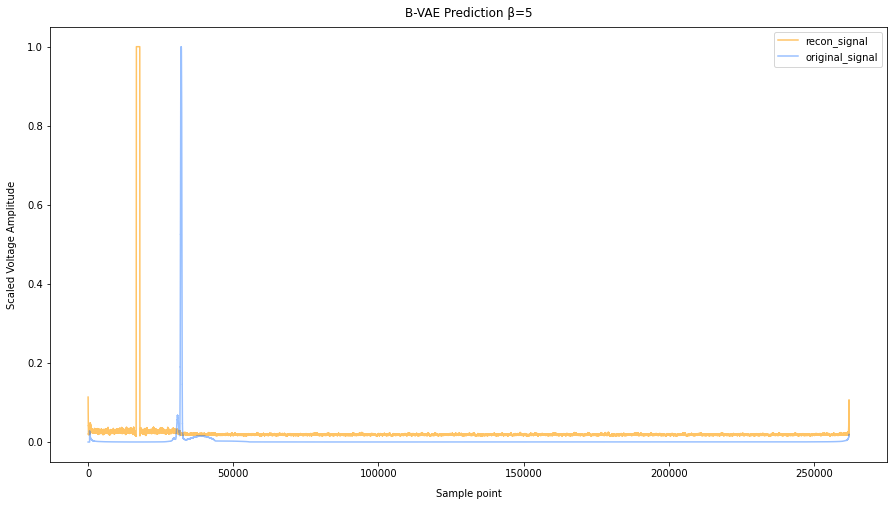

(300, 1)


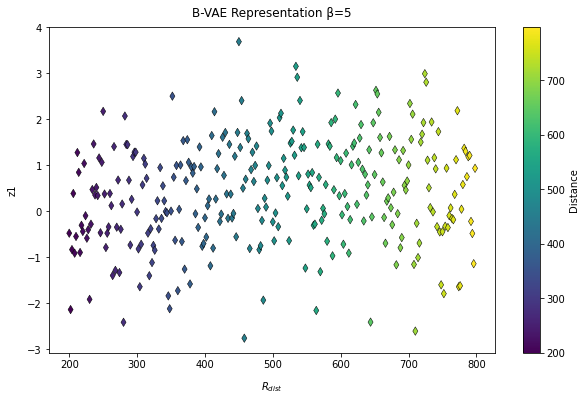

In [ ]:
n = 'e10_b5'
var_dict[n].train()
n_recon = var_dict[n].predict(X_test)
n_latent_z = var_dict[n].latent_pred(X_test)

Train on 100 samples
Epoch 1/1000
100/100 [==============================] - 15s 153ms/sample - loss: 8.1876
Epoch 2/1000
100/100 [==============================] - 0s 5ms/sample - loss: 7.9057
Epoch 3/1000
100/100 [==============================] - 0s 5ms/sample - loss: 7.6473
Epoch 4/1000
100/100 [==============================] - 0s 5ms/sample - loss: 7.3913
Epoch 5/1000
100/100 [==============================] - 0s 5ms/sample - loss: 7.1160
Epoch 6/1000
100/100 [==============================] - 0s 5ms/sample - loss: 6.8034
Epoch 7/1000
100/100 [==============================] - 0s 5ms/sample - loss: 6.4315
Epoch 8/1000
100/100 [==============================] - 0s 5ms/sample - loss: 5.9567
Epoch 9/1000
100/100 [==============================] - 0s 5ms/sample - loss: 5.4162
Epoch 10/1000
100/100 [==============================] - 0s 5ms/sample - loss: 4.8029
Epoch 11/1000
100/100 [==============================] - 0s 5ms/sample - loss: 4.1383
Epoch 12/1000
100/100 [================

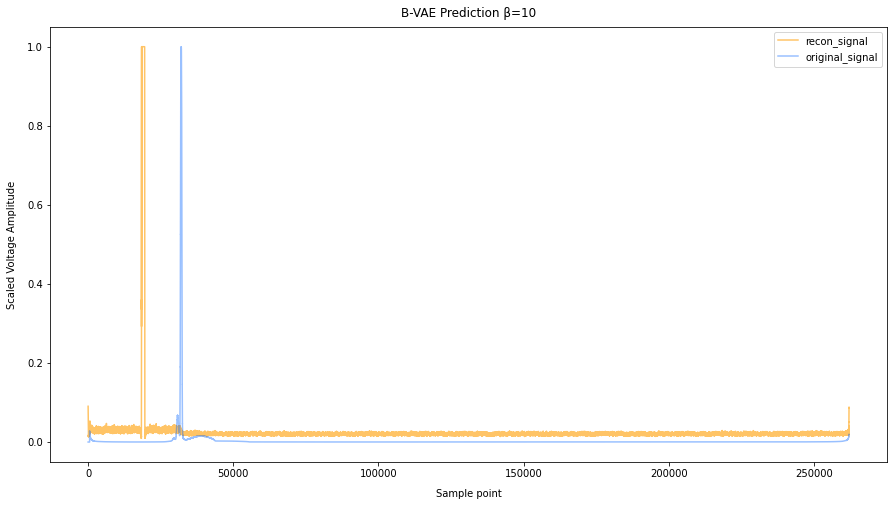

(300, 1)


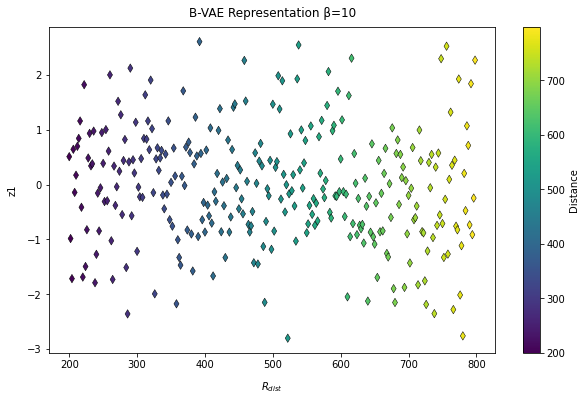

In [ ]:
n = 'e10_b10'
var_dict[n].train()
n_recon = var_dict[n].predict(X_test)
n_latent_z = var_dict[n].latent_pred(X_test)

Train on 100 samples
Epoch 1/1000
100/100 [==============================] - 16s 159ms/sample - loss: 670.8459
Epoch 2/1000
100/100 [==============================] - 0s 5ms/sample - loss: 400.1768
Epoch 3/1000
100/100 [==============================] - 0s 5ms/sample - loss: 304.6394
Epoch 4/1000
100/100 [==============================] - 0s 5ms/sample - loss: 258.9075
Epoch 5/1000
100/100 [==============================] - 0s 5ms/sample - loss: 234.5659
Epoch 6/1000
100/100 [==============================] - 0s 5ms/sample - loss: 217.9320
Epoch 7/1000
100/100 [==============================] - 0s 5ms/sample - loss: 207.4655
Epoch 8/1000
100/100 [==============================] - 0s 5ms/sample - loss: 199.0770
Epoch 9/1000
100/100 [==============================] - 0s 5ms/sample - loss: 192.6200
Epoch 10/1000
100/100 [==============================] - 0s 5ms/sample - loss: 187.8517
Epoch 11/1000
100/100 [==============================] - 0s 5ms/sample - loss: 183.2620
Epoch 12/1000
100

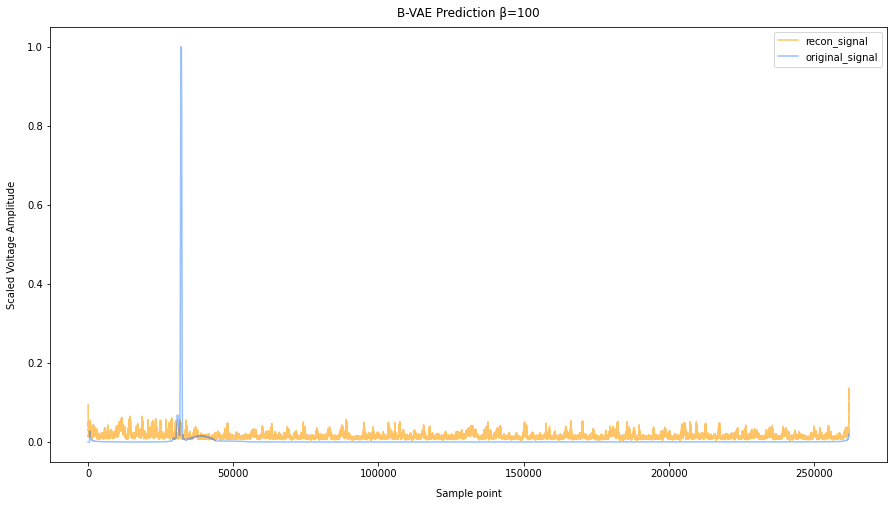

(300, 1)


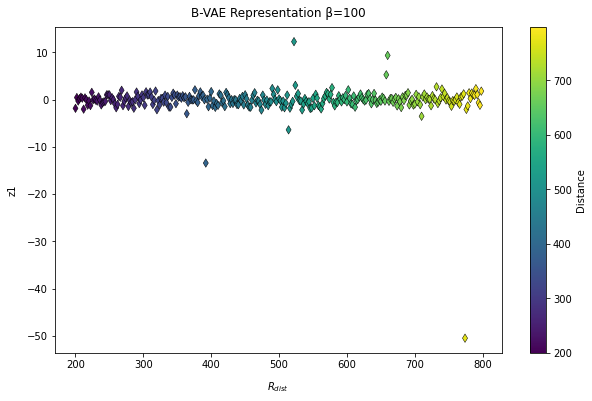

In [ ]:
n = 'e10_b100'
var_dict[n].train()
n_recon = var_dict[n].predict(X_test)
n_latent_z = var_dict[n].latent_pred(X_test)